In [9]:
from twitter_ner.src import config
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, BertTokenizerFast, TFBertModel, TFAutoModel, TFRobertaModel
import warnings
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pydot
import graphviz
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

MAX_LEN = int(config.MAX_LEN)

def set_vars():
    if config.MODEL == 1:
        _base_model_path = "vinai/bertweet-base"
        _tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)
        _pretrained_model = TFAutoModel.from_pretrained("vinai/bertweet-base")
        _model_name = "bertweet_"
    elif config.MODEL == 0:
        _base_model_path = "bert-base-uncased"
        _tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
        _pretrained_model = TFBertModel.from_pretrained('bert-base-uncased')
        _model_name = "bert_"

    if config.DATASET == 1:
        _training_file = "twitter_ner/data/twitter_train_dev.csv"
        _testing_file = "twitter_ner/data/twitter_test.csv"
        _model_name += "twitter"
    elif config.DATASET == 0:
        _training_file = "twitter_ner/data/news_train_dev.csv"
        _testing_file = "twitter_ner/data/news_test.csv"
        _model_name += "news"
    return _base_model_path, _tokenizer, _pretrained_model, _training_file, _testing_file, _model_name

def create_model(bert_model,max_len = MAX_LEN):
    input_ids = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    bert_output = bert_model(input_ids,attention_mask = attention_masks, return_dict =True)
    embedding = tf.keras.layers.Dropout(0.3)(bert_output["last_hidden_state"])
    output = tf.keras.layers.Dense(17,activation = 'softmax')(embedding)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = [output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def load_model():
    if config.MODEL == 1:
        _loaded_model = tf.keras.models.load_model(config.MODEL_PATH + model_name,
                                                  custom_objects={"TFRobertaModel": TFRobertaModel})

    elif config.MODEL == 0:
        _loaded_model = tf.keras.models.load_model(config.MODEL_PATH + model_name,
                                                  custom_objects={"TFBertModel": TFBertModel})
    return _loaded_model

def tokenize(data,max_len = MAX_LEN):
    _input_ids = list()
    attention_mask = list()
    for n in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(data[n],
                                        add_special_tokens = True,
                                        max_length = MAX_LEN,
                                        is_split_into_words=True,
                                        return_attention_mask=True,
                                        padding = 'max_length',
                                        truncation=True,return_tensors = 'np')


        _input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
    return np.vstack(_input_ids),np.vstack(attention_mask)

def process_data(data_path):
    #Pandas wants to warn us about behavior in the version we are using. We want this behavior
    warnings.simplefilter("ignore", category=FutureWarning)

    df = pd.read_csv(data_path, encoding="utf-8")
    df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method="ffill")
    #df[df.columns[0]] = df["Sentence #"].fillna(method="ffill")
    #df.isetitem(0, df["Sentence #"].fillna(method="ffill"))

    _enc_pos = preprocessing.LabelEncoder()
    _enc_tag = preprocessing.LabelEncoder()

    df.loc[:, "POS"] = _enc_pos.fit_transform(df["POS"])
    #df[df.columns[1]] = _enc_pos.fit_transform(df["POS"])
    #df.isetitem(1, _enc_pos.fit_transform(df["POS"]))
    df.loc[:, "Tag"] = _enc_tag.fit_transform(df["Tag"])
    #df[df.columns[2]] = _enc_pos.fit_transform(df["Tag"])
    #df.isetitem(2, _enc_pos.fit_transform(df["Tag"]))

    sentences = df.groupby("Sentence #")["Word"].apply(list).values
    _pos = df.groupby("Sentence #")["POS"].apply(list).values
    _tag = df.groupby("Sentence #")["Tag"].apply(list).values
    return sentences, _pos, _tag, _enc_pos, _enc_tag

In [10]:
base_model_path, tokenizer, pretrained_model, training_file, testing_file, model_name = set_vars()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Num GPUs Available:  1


In [11]:
dataframe = pd.read_csv(training_file,encoding = 'utf-8', on_bad_lines = 'skip')
dataframe = dataframe.dropna()
dataframe.head()

print(f"Number of Tags : {len(dataframe.Tag.unique())}")
pie = dataframe['Tag'].value_counts()
px.pie(names = pie.index,values= pie.values,hole = 0.5,title ='Total Count of Tags')

print(f"Number of POS Tags : {len(dataframe['POS'].unique())}")
bar = dataframe['POS'].value_counts()
px.bar(x = bar.index,y = bar.values,title = "Total Count of Parts of Speech",color = bar.index)

Number of Tags : 9
Number of POS Tags : 29


In [12]:
sentence,pos,tag,enc_pos,enc_tag = process_data(training_file)

In [13]:
X_train,X_test,y_train,y_test = train_test_split(sentence,tag,random_state=42,test_size=0.1)
X_train.shape,X_test.shape,y_train.shape,y_test.shape


input_ids,attention_mask = tokenize(X_train,max_len = MAX_LEN)
val_input_ids,val_attention_mask = tokenize(X_test,max_len = MAX_LEN)

# TEST: Checking Padding and Truncation length's
was = list()
for i in range(len(input_ids)):
    was.append(len(input_ids[i]))
set(was)

# Train Padding
test_tag = list()
for i in range(len(y_test)):
    test_tag.append(np.array(y_test[i] + [0] * (128-len(y_test[i]))))

# TEST:  Checking Padding Length
was = list()
for i in range(len(test_tag)):
    was.append(len(test_tag[i]))
set(was)

# Train Padding
train_tag = list()
for i in range(len(y_train)):
    train_tag.append(np.array(y_train[i] + [0] * (128-len(y_train[i]))))

# TEST:  Checking Padding Length
was = list()
for i in range(len(train_tag)):
    was.append(len(train_tag[i]))
set(was)

100%|██████████| 4317/4317 [00:01<00:00, 3997.23it/s]


{128}

In [14]:
model = create_model(pretrained_model,MAX_LEN)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

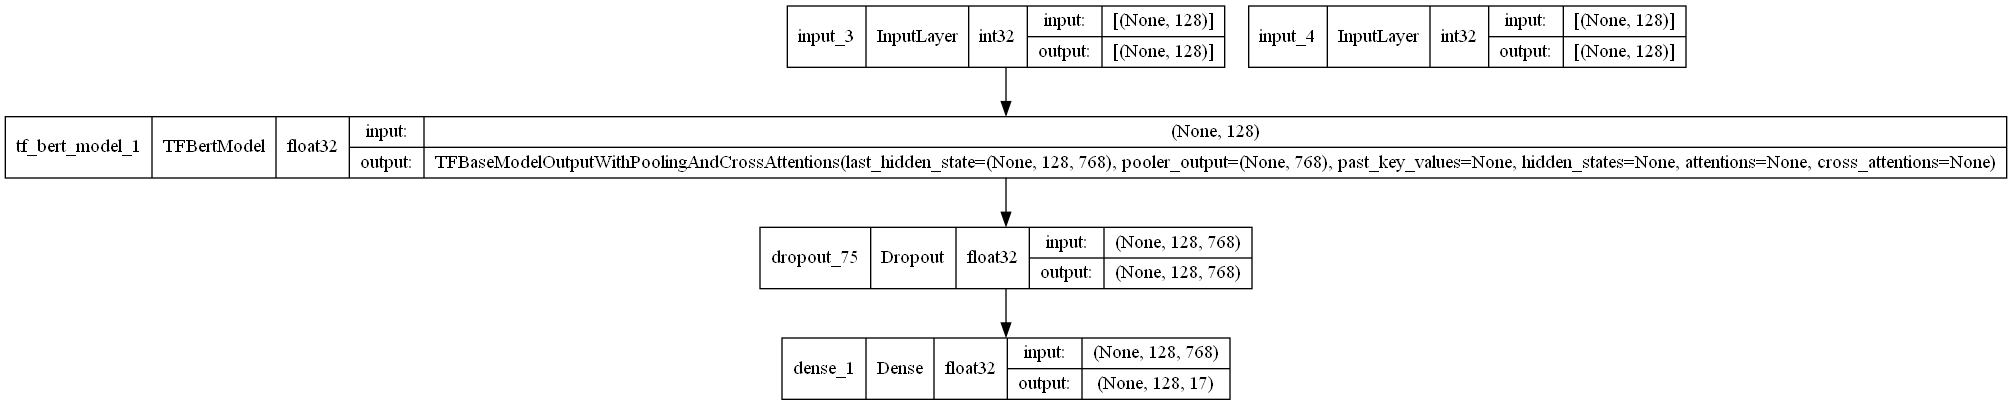

In [15]:
tf.keras.utils.plot_model(model,show_shapes=True, show_dtype=True)

In [16]:
early_stopping = EarlyStopping(mode='min',patience=5)
print("tf device memory in use: " + str(tf.config.experimental.get_memory_info("GPU:0")['current']))
history_bert = model.fit([input_ids, attention_mask],
                         np.array(train_tag),
                         validation_data = ([val_input_ids,val_attention_mask],np.array(test_tag)),
                         epochs = config.EPOCHS,batch_size = config.TRAIN_BATCH_SIZE,
                         callbacks = early_stopping,verbose = True)

tf device memory in use: 1835546880
Epoch 1/2


KeyboardInterrupt: 

In [ ]:
model.save(config.MODEL_PATH + model_name, save_format="h5", include_optimizer=False)
print("done")

In [ ]:
loaded_model = load_model()

In [ ]:
plt.plot(history_bert.history['accuracy'])
plt.plot(history_bert.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_bert.history['loss'])
plt.plot(history_bert.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()